In [1]:
import re
import pprint
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from math import sqrt
import warnings
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import pyproj as proj
import copy

## After making my imports, I worked with New York data as the base for my model

### While it is certainly the case that other cities will function differently than New York, I wanted to build out my working model with this city, as it has the largest amount of data available to start and has a large variety of pricing options, I would really enjoy moving my price bins to reflect different cities better to increase the quality of my model in various cities. This is the version of my code without any amenities present.

In [2]:
NY = pd.read_csv('data/NYListings.csv')

In [3]:
def clean_price(strngy):
    """
    Quick function to strip formatting from dollars
    """
    dols = strngy.replace('$', '')
    dols = dols.replace(',', '')
    dols = float(dols)
    return dols

def clean_amens(amenity):
    """
    Quick function to unpack amenities into list
    """
    amenity = amenity.replace('{','')
    amenity = amenity.replace('}','')
    amenity = amenity.replace('"','')
    amenlist = amenity.split(',')
    return amenlist
    
def clean_DF(DF, region):
    """
    Clean_DF does what it says, it takes in a cityDF, then initially drops any columns
    that won't be used, and proceeds to fill out ones that will be needed with some 
    assumed values.
    """
    #Dropping undesirable columns...
    DF = DF[desired]
    
    DF.cleaning_fee.fillna(value = '$0.00', inplace = True)

    DF.price = DF.price.apply(clean_price)
    DF.cleaning_fee = DF.cleaning_fee.apply(clean_price)

    DF = DF[DF['price'] != 0]
    DF = DF[np.isfinite(DF.bathrooms)]
    DF = DF[np.isfinite(DF.bedrooms)]
    DF = DF[np.isfinite(DF.beds)]
    
    #Drop Other property types, these accounted for a very small amount of rows
    #it included various interesting structures such as yurts and teepees.
    prop_types = ['Apartment', 'House', 'Townhouse', 'Loft', 'Condominium']
    DF = DF[DF['property_type'].isin(prop_types)]
    
    
    return DF

In [4]:
desired = [
 'property_type','room_type','accommodates','bathrooms',
 'bedrooms','beds','price','cleaning_fee', 'latitude', 'longitude']

In [5]:
nyc = clean_DF(NY, 'New York City')

#### Here I am just running my NY dataframe through the cleaning function, I ended up dropping many columns from the dataframe as I found them to have little signal after doing EDA on them. There were many columns that I thought would have significantly more signal. Ones with booleans, ones regarding host information, listing information, etc. Some of the columns I want to explore in the future would be the ones with regular language to see if there would be any NLP that can be done to try to get closer to the prices that are being asked for rentals

In [6]:
nyc[nyc.bathrooms == 17]

,property_type,room_type,accommodates,bathrooms,bedrooms,beds,price,cleaning_fee,latitude,longitude
44853,House,Shared room,2,17.0,1.0,2.0,35.0,30.0,40.696762,-73.939594


#### Above is a pretty classic example of a listing that would throw off any attempts at a model, this is why I will be cleaning the bedroom and bathroom columns below.

In [7]:
nyc.price = np.array(nyc.price)+np.array(nyc.cleaning_fee)
nyc.drop(labels='cleaning_fee', axis=1, inplace=True)

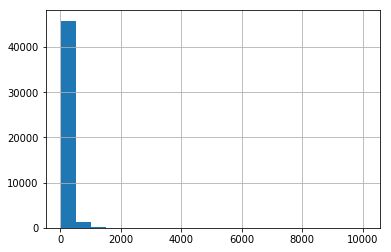

In [8]:
nyc.price.hist(bins=20);

In [9]:
len(nyc)

47421

In [10]:
nyc = nyc[nyc['price'] <= 500]

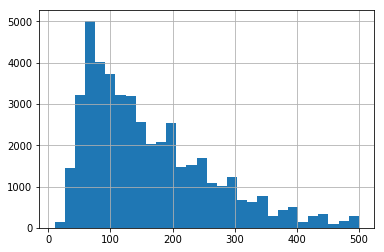

In [11]:
nyc.price.hist(bins=30);

In [12]:
len(nyc)

45765

In [13]:
nyc.price = pd.cut(nyc.price, bins=[1,150,300,400,500], right=True) #best
#nyc.price = pd.cut(nyc.price, bins=[1,100,200,300,400,500], right=True)
#nyc.price = pd.cut(nyc.price, bins=[1,100,150,250,500], right=True)

In [14]:
nyc.price.value_counts()

(1, 150]      26001
(150, 300]    15189
(300, 400]     3289
(400, 500]     1286
Name: price, dtype: int64

In [15]:
nyc = nyc[nyc['bedrooms'] <= 5]
nyc = nyc[nyc['beds'] <= 6]
nyc = nyc[nyc['bathrooms'] <= 4]
nyc = nyc[nyc['accommodates'] <= 10]

In [16]:
len(nyc)

45586

#### Here I am just showing how the histograms looked before and after the data cleaning, and showing how many entries I am losing as I clean up my data, going from ~47,500 non-zero priced listings to about ~45,500 as my input for my final model. One of the funny things to note here is the spike that happens near the round numbers of 200, 300, 400, and 500. In other cities this effect was much more pronounced, and can be seen in the presentation I have included. 

In [17]:
input_lon = np.array(nyc.longitude)
input_lat = np.array(nyc.latitude)

#### In the next cell, I am converting the latitude and longitudes of NYC into meters using the Pyproj library, this is something that ended up causing me some grief with other cities that I was trying to predict on (so they will have a slightly different process, shown in a different file). The issue that I was coming across consistently was that cities east of the Mississippi river were coming up without any issues, while cities to the west would cause arrays full of "inf"s to appear. The issue was that the values entered here were tied to a UK grid, so they didn't extend all the way across the United States, just far enough for a few of the cites to work, while causing problems for others. The other model I make will use the latitude and longitude as straight X-Y coordinates instead of projecting them. At this point, I haven't found a working projection within Pyproj that I can use, but when I do I would be updating this code with my other cities, as converting everything to meters helped my predictions quite a bit.

In [18]:
crs_wgs = proj.Proj(init='epsg:4326') 
crs_bng = proj.Proj(init='epsg:27700') 
x_points, y_points = proj.transform(crs_wgs, crs_bng, input_lon, input_lat)

In [19]:
x_try = x_points/np.mean(x_points)
y_try = y_points/np.mean(y_points)

In [20]:
new_x_points = np.round(x_try, 4)
new_y_points = np.round(y_try, 4)

In [21]:
nyc['lats'] = new_x_points
nyc['longs'] = new_y_points

In [22]:
nyc.price = [i.replace(')',']') for i in list(map(str, nyc.price))]

In [23]:
nyc.columns

Index(['property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price', 'latitude', 'longitude', 'lats', 'longs'],
      dtype='object')

In [24]:
no_dum_nyc = nyc[['accommodates', 'bathrooms', 'bedrooms',
       'beds', 'price', 'lats', 'longs']]

In [25]:
x_nodum = no_dum_nyc.drop('price', axis=1)
y_nodum = no_dum_nyc.price

In [26]:
x_nodum_train, x_nodum_test, y_nodum_train, y_nodum_test = train_test_split(x_nodum.values.tolist(), list(y_nodum), test_size=.50)

In [27]:
rf = RandomForestClassifier(n_estimators=1000, criterion ='entropy', min_samples_split=2,
                            min_samples_leaf=50, n_jobs=16, bootstrap=True, warm_start=True, random_state=42)

#### While creating my classifier, I was having issues with n_jobs = -1 (it wasn't showing 16 busy cores in htop for some reason, so I had manually set it to n_jobs = 16 and it began showing them all being busy in htop. I wasn't sure what had caused this, but the fix worked so I didn't change everything around for it. If you would like to run this code on a standard machine, I recommend setting -1 here.

In [28]:
def evaluate_rf(model, test_features, test_labels):
    predictions = model.predict(test_features)
    results = [1 if i == j else 0 for (i,j) in zip(predictions, test_labels)]
    accuracy = sum(results)/len(results)
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

In [29]:
for i in range(10):
    rf.fit(x_nodum_train, y_nodum_train)
    rf.n_estimators += 100
    print (evaluate_rf(rf, x_nodum_test, y_nodum_test))

Accuracy = 0.71%.
0.7066204536480498
Accuracy = 0.71%.
0.7066643267669899
Accuracy = 0.71%.
0.7070153117185101
Accuracy = 0.71%.
0.7067081998859299
Accuracy = 0.71%.
0.7066204536480498
Accuracy = 0.71%.
0.7067959461238099
Accuracy = 0.71%.
0.7067959461238099
Accuracy = 0.71%.
0.7067959461238099
Accuracy = 0.71%.
0.70683981924275
Accuracy = 0.71%.
0.7067081998859299


#### This is a nice piece of code I found online which allows me to very neatly output the feature importance in a dataframe, it is used below with XGBoost as well...

In [30]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                  index = x_nodum.columns,
                                  columns=['importance']).sort_values('importance', ascending=False)

In [31]:
feature_importances

,importance
accommodates,0.332861
longs,0.255548
bedrooms,0.166973
lats,0.123917
beds,0.095467
bathrooms,0.025235


#### The above code can be pretty easily ported to the other cities eastern cities (Boston, Washington DC, and New Orleans), however the western cities will cause problems, so they are in a more general model where I continue to use the latitude and longitude rather than meters. Below, I have included code for some searching of hyperparameters, and then I begin XGBoosting.

In [32]:
# from sklearn.model_selection import RandomizedSearchCV

# # Number of trees in random forest

# n_estimators = [100]

# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']

# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(1, 7, num = 1)]

# # Minimum number of samples required to split a node
# min_samples_split = [2,4,5,6,7]

# # Minimum number of samples required at each leaf node
# min_samples_leaf = [5,10,50,75,100,1000,5000]

# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

In [33]:
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=140, cv=3, verbose=2, random_state=42, n_jobs=-1)

In [34]:
# # Fit the random search model
# rf_random.fit(x_nodum_train, y_nodum_train)

In [35]:
# rf_random.best_params_

In [36]:
# def evaluate(model, test_features, test_labels):
#     predictions = model.predict(test_features)
#     results = [1 if i == j else 0 for (i,j) in zip(predictions, test_labels)]
#     accuracy = sum(results)/len(results)
#     print('Accuracy = {:0.2f}%.'.format(accuracy))
#     return accuracy

In [37]:
# best_random = rf_random.best_estimator_
# random_accuracy = evaluate(best_random, x_nodum_test, y_nodum_test)

In [38]:
##### START XGBoost #####

In [39]:
xg = XGBClassifier(objective='multi:softmax', n_jobs=16) #default estimators is 100
xg.fit(np.array(x_nodum_train), np.array(y_nodum_train))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=16, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [40]:
y_pred = xg.predict(x_nodum_test)
accuracy = accuracy_score(y_nodum_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 70.86%


In [41]:
xg = XGBClassifier(objective='multi:softmax', n_estimators=1000, n_jobs=16) 
xg.fit(np.array(x_nodum_train), np.array(y_nodum_train))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=16, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [42]:
y_pred = xg.predict(x_nodum_test)
accuracy = accuracy_score(y_nodum_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 71.02%


In [43]:
xg = XGBClassifier(objective='multi:softmax', n_estimators=1000, learning_rate=0.15, n_jobs=16) 
xg.fit(np.array(x_nodum_train), np.array(y_nodum_train))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.15, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=16, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [44]:
y_pred = xg.predict(x_nodum_test)
accuracy = accuracy_score(y_nodum_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 70.93%


In [45]:
xg = XGBClassifier(objective='multi:softmax', n_estimators=3000, 
                   learning_rate=0.1, n_jobs=16) 
xg.fit(np.array(x_nodum_train), np.array(y_nodum_train))

y_pred = xg.predict(x_nodum_test)
accuracy = accuracy_score(y_nodum_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 70.63%


In [46]:
xg = XGBClassifier(objective='multi:softmax', n_estimators=1100, 
                   learning_rate=0.05, updater='grow_colmaker,prune', n_jobs=16) 

xg.fit(np.array(x_nodum_train), np.array(y_nodum_train))

y_pred = xg.predict(x_nodum_test)
accuracy = accuracy_score(y_nodum_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 71.07%


#### Above, I spent some time trying to find the most accurate hyperparameters for XGBoost, there were many more iterations of this happening as well, but not all of them made it into the final code, as there would be times when I would simply throw code away when I made more significant improvements after the fact. Below, I show the feature importances for the final XGBoost classifier that I used.

In [47]:
xg.feature_importances_

array([0.11149673, 0.06396814, 0.0716034 , 0.05487159, 0.33485553,
       0.36320463], dtype=float32)

In [48]:
feature_importances = pd.DataFrame(xg.feature_importances_,
                                  index = x_nodum.columns,
                                  columns=['importance']).sort_values('importance', ascending=False)

In [49]:
feature_importances

,importance
longs,0.363205
lats,0.334856
accommodates,0.111497
bedrooms,0.071603
bathrooms,0.063968
beds,0.054872
